In [1]:
import os
import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample
from scipy.stats import mode

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
data_dir = "../../data/dataset/"
subjects = os.listdir(data_dir)
gestures = config.GESTURES
learning_rate = 3e-4
img_len = 75

In [3]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

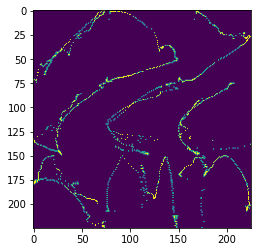

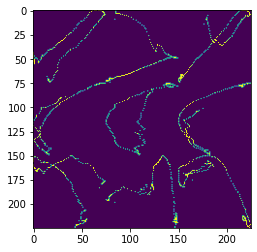

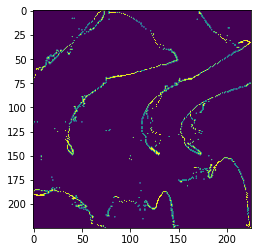

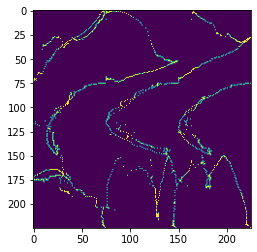

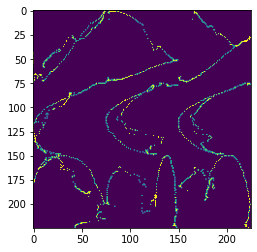

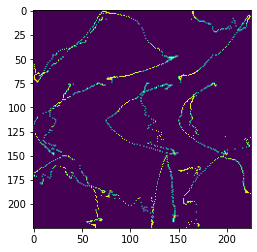

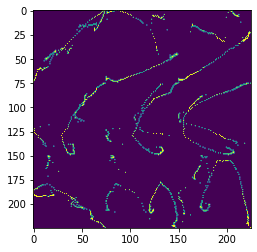

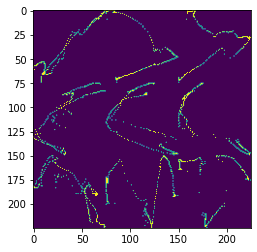

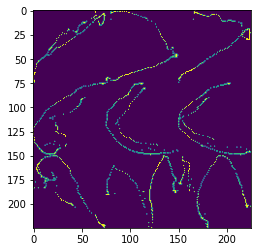

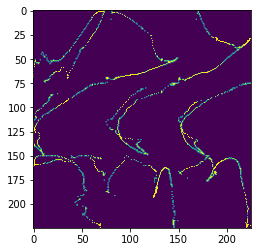

,index,rpx,rpy,rpz,lpx,lpy,lpz,rf0x,rf0y,rf0z,...,lf2x,lf2y,lf2z,lf3x,lf3y,lf3z,lf4x,lf4y,lf4z,label
0,0,67.703769,11.157653,50.363848,0.0,12.5,0.000000,9.722654,3.806308,58.630519,...,0.000,0.00,0.000000,0.000000,25.0,0.0,0.0,0.000000,0.000000,0
1,1,66.692174,12.824592,46.769920,25.0,25.0,13.636364,0.000000,4.219751,58.098754,...,28.125,25.00,10.714286,23.076923,25.0,0.0,30.0,32.142857,27.272727,0
2,2,67.069461,12.200958,48.169470,75.0,75.0,61.363636,3.692502,4.072183,58.303319,...,75.000,68.75,64.285714,69.230769,50.0,37.5,60.0,64.285714,71.590909,0
3,3,66.851926,12.569388,47.411769,75.0,50.0,54.545455,1.525007,4.177738,58.275726,...,56.250,62.50,53.571429,63.461538,25.0,37.5,60.0,53.571429,61.363636,0
4,4,66.989733,12.323118,47.964528,75.0,50.0,54.545455,3.028769,4.110181,58.301983,...,56.250,68.75,64.285714,69.230769,50.0,37.5,60.0,53.571429,64.772727,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,251,70.226446,0.345164,73.433026,50.0,50.0,54.545455,71.550747,0.935010,69.762334,...,56.250,68.75,64.285714,63.461538,75.0,37.5,60.0,42.857143,64.772727,0
2556,252,70.394135,0.595234,72.314046,50.0,50.0,54.545455,70.190056,1.232991,68.628041,...,56.250,68.75,64.285714,63.461538,75.0,37.5,60.0,53.571429,64.772727,0
2557,253,70.409140,0.269835,73.793646,75.0,50.0,54.545455,72.680088,1.535554,68.497151,...,56.250,68.75,53.571429,69.230769,25.0,37.5,60.0,64.285714,64.772727,0
2558,254,70.618727,0.705412,71.861762,75.0,50.0,54.545455,70.457851,1.897434,67.049806,...,56.250,62.50,53.571429,63.461538,25.0,37.5,60.0,53.571429,64.772727,0


In [5]:
dataset = pd.DataFrame()

for subject in subjects:
    for gesture in config.GESTURES:
        gesture_dir = os.path.join(data_dir, subject, gesture)
        recordings = os.listdir(gesture_dir)
        for recording in recordings:
            file_path = os.path.join(gesture_dir, recording)
            data = pd.read_csv(file_path)
            data.drop(columns=["time"], inplace=True)
            data.drop(0, inplace=True) # Remove first All-0 row
            data = data.apply(resample, args=(config.SEGMENT_LEN, None, 0))
            data = (data - data.min()) / (data.max() - data.min()) * 75
            data["label"] = config.GESTURES.index(gesture)

            dataset = pd.concat([dataset, data])

            rpx = data["rpx"].to_numpy()
            rpy = data["rpy"].to_numpy()
            rpz = data["rpz"].to_numpy()

            rf0x = data["rf0x"].to_numpy()
            rf0y = data["rf0y"].to_numpy()
            rf0z = data["rf0z"].to_numpy()

            rf1x = data["rf1x"].to_numpy()
            rf1y = data["rf1y"].to_numpy()
            rf1z = data["rf1z"].to_numpy()

            rpx = (normalize(rpx) * (img_len - 1)).astype("uint8")
            rpy = (normalize(rpy) * (img_len - 1)).astype("uint8")
            rpz = (normalize(rpz) * (img_len - 1)).astype("uint8")

            rf0x = (normalize(rf0x) * (img_len - 1)).astype("uint8")
            rf0y = (normalize(rf0y) * (img_len - 1)).astype("uint8")
            rf0z = (normalize(rf0z) * (img_len - 1)).astype("uint8")

            rf1x = (normalize(rf1x) * (img_len - 1)).astype("uint8")
            rf1y = (normalize(rf1y) * (img_len - 1)).astype("uint8")
            rf1z = (normalize(rf1z) * (img_len - 1)).astype("uint8")

            img = np.zeros((img_len * 3, img_len * 3), dtype="uint8")

            img[rpx, rpy] = 1
            img[rpy + 75, rpz] = 1
            img[rpz + 150, rpx] = 1

            img[rf0x, rf0y + 75] = 1
            img[rf0y + 75, rf0z + 75] = 1
            img[rf0z + 150, rf0x + 75] = 1

            img[rf1x, rf1y + 150] = 1
            img[rf1y + 75, rf1z + 150] = 1
            img[rf1z + 150, rf1x + 150] = 1

            plt.imshow(img)
            plt.show()

            
        break
    break

dataset.reset_index(inplace=True)
dataset

In [ ]:
img_xy

In [ ]:
features = dataset[["rpx", "rpy", "rpz"] + ["label"]]
features

In [ ]:
X = features.drop(columns=["label"]).to_numpy()
X = X.reshape((-1, config.SEGMENT_LEN, 3))

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[0, :, 0], X[0, :, 1])